In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264,
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24,
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]

# KNN regression

So far you're familiar with KNN as a classifier; in other words, you know how to use it to assign observations to categories or assign probabilities to the various categories. However, KNN is also a reasonable algorithm for regression. It's a simple extension of what you've learned before, and it's just as easy to implement.

## Everything's the same

Switching KNN to a regression is a simple process. In the previous models, each of the $k$ observations voted for a _category_. As a regression, they vote instead for a _value_. Then, instead of taking the most popular response, the algorithm averages all of the votes. If you have weights, you perform a weighted average.

It's really that simple.

Now, go over a quick example just to confirm your understanding.

Stick with the world of music for now. Instead of trying to classify songs as rock or jazz, take the same data with an additional column: beats per minute (BPM). Can you train your model to predict BPM?

First, try to predict BPM just in terms of loudness, because this will be easier to represent graphically.

In [2]:
from sklearn import neighbors

# Build the model
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn.fit(X, Y)

KNeighborsRegressor(n_neighbors=10)

Once you have fit your model, you can use it to predict BPM, given a set of values for loudness. You can use this approach to visualize the relationship that the model learned between the two variables (loudness and BPM). To do this, generate a set of incrementing loudness variables (`T`), pass them to your model, and have the model generate corresponding BPM values based on what it has learned.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


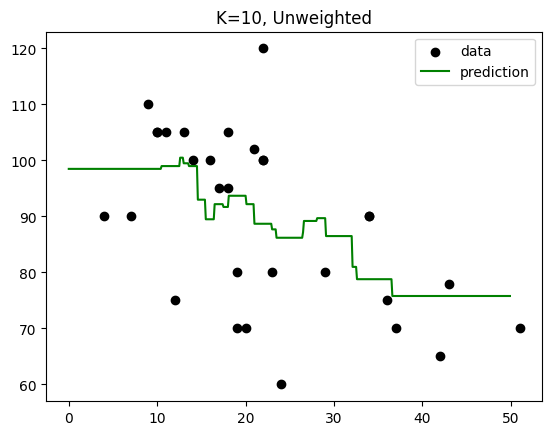

In [3]:
# Generating a set of loudness values between `0` and `50`, incrementing by `0.1`
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Generating predictions for each of the loudness values
Y_ = knn.predict(T)

# Plotting the training data and the prediction line for the newly generated loudness values
plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

The scatter points in the chart above represent the loudness and BPM value combinations that the model learned from. The prediction line in the chart visually conveys the patterns that the model has learned from those loudness and BPM value combinations.

## Adding weights to your model

By default, the KNN model in scikit-learn weighs all neighbors equally. You can change this behavior by modifying the model's `weights` parameter. Next, see what happens when you run the same model but explicitly set the weights to be based on distance, so that closer neighbors of a point will have a greater influence than neighbors that are further away.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


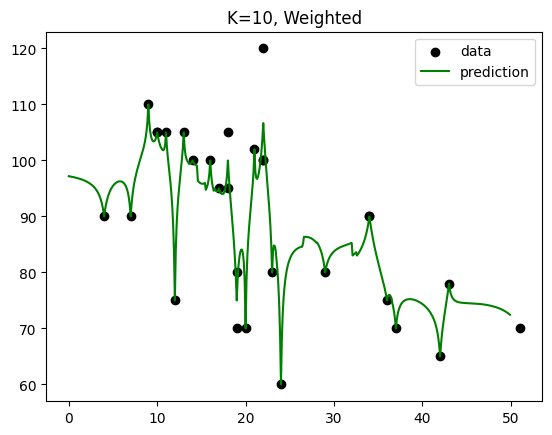

In [4]:
# Run the same model, this time with weights
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up the prediction line
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

Notice how it seems like the weighted model grossly overfits to points. It is interesting that it oscillates around the data points. This is because the decay in weight happens so quickly. In other words, the weight with which a neighbor influences the prediction quickly decreases the further away that neighbor is.


## Validating KNN

Validating KNN, whether a regression or a classifier, is pretty much exactly the same as evaluating other classifiers or regression models. Cross-validation is still tremendously valuable, you can do holdouts, and you even still get an $R^2$ value for the regression.

Below, validate that overfitting of the previous model with some k-fold cross-validation. The test statistic given by this model is $R^2$, which measures the same thing as in linear regression.

In [5]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)


As you can see, these two models are fantastically awful. There doesn't seem to be much of a relationship. It's all very poor. However, the increased variance in the weighted model is interesting.

Go ahead and add the other feature and mess around with $k$ and weighting; see if you can do any better!

In [6]:
## Helper function for testing regression with KNNs

def build_test_knn_regressor(X,Y,X_train,Y_train,X_test,Y_test,**kwargs):
    n_neighbors = kwargs.get('n_neighbors',5)
    weights = kwargs.get('weights','uniform')
    cv = kwargs.get('cv',5)
    addl_title_text = "n_neighbors = {}, weights = {}".format(n_neighbors,weights)
    knn = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors,weights=weights)
    knn.fit(X_train, Y_train)

    Y_ = knn.predict(X_train)
    ax = sns.regplot(x=Y_train,y=Y_.flatten(),scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "green"})
    ax.set(xlabel='Test value', ylabel='Predicted value',
           title='BPM: Training values vs. predicted values; {}'.format(addl_title_text))
    plt.show()
    score_train = cross_val_score(knn, X_train, Y_train, cv=cv)
    print("Training Accuracy: %0.2f (+/- %0.2f)" % (score_train.mean(), score_train.std() * 2))

    Y_ = knn.predict(X_test)
    ax = sns.regplot(x=Y_test,y=Y_.flatten(),scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "green"})
    ax.set(xlabel='Test value', ylabel='Predicted value',
           title='BPM: Test values vs. predicted values; {}'.format(addl_title_text))
    plt.show()
    score_test = cross_val_score(knn, X_test, Y_test, cv=cv)
    print("Training Accuracy: %0.2f (+/- %0.2f)" % (score_test.mean(), score_test.std() * 2))

    Y_ = knn.predict(X)
    ax = sns.regplot(x=Y,y=Y_.flatten(),scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "green"})
    ax.set(xlabel='Actual value', ylabel='Predicted value',
           title='BPM: Actual values vs. predicted values; {}'.format(addl_title_text))
    plt.show()
    score = cross_val_score(knn, X, Y, cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

In [7]:
## Your model here.

X = music.drop(columns='bpm')
Y = pd.DataFrame(music['bpm'])

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 24
The number of observations in test set is 6


Testing against uniform weighting:

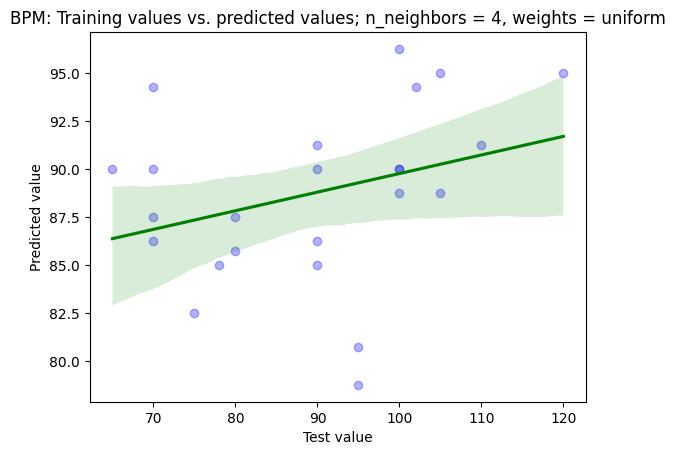

Training Accuracy: -0.10 (+/- 0.55)


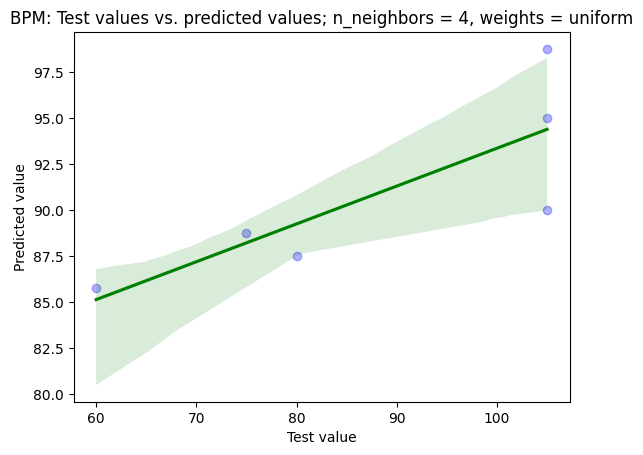

Training Accuracy: -14.13 (+/- 39.76)


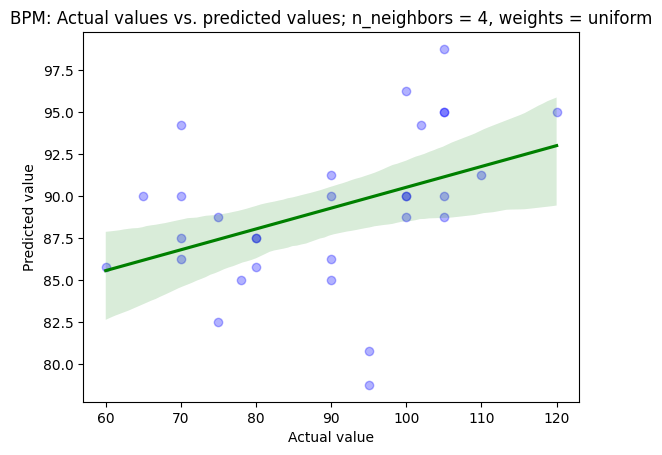

Accuracy: -0.42 (+/- 0.17)


In [8]:
build_test_knn_regressor(X,Y,X_train,Y_train,X_test,Y_test,n_neighbors=4,cv=3)

Testing against weighting by distance:

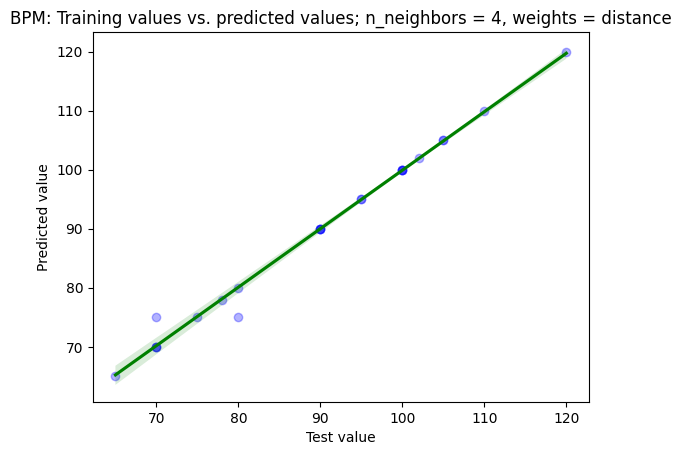

Training Accuracy: -0.08 (+/- 0.76)


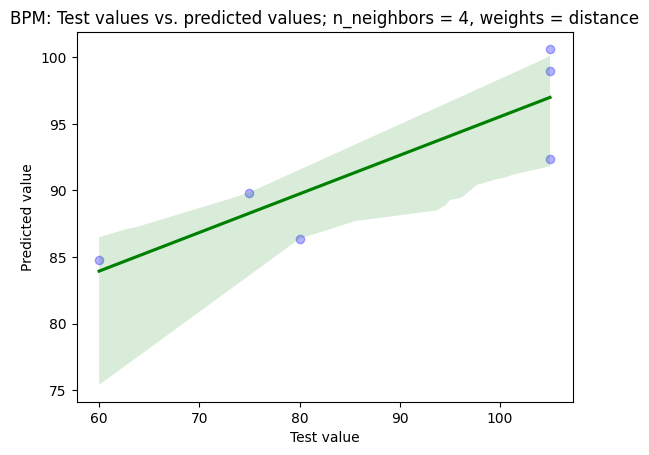

Training Accuracy: -12.12 (+/- 34.77)


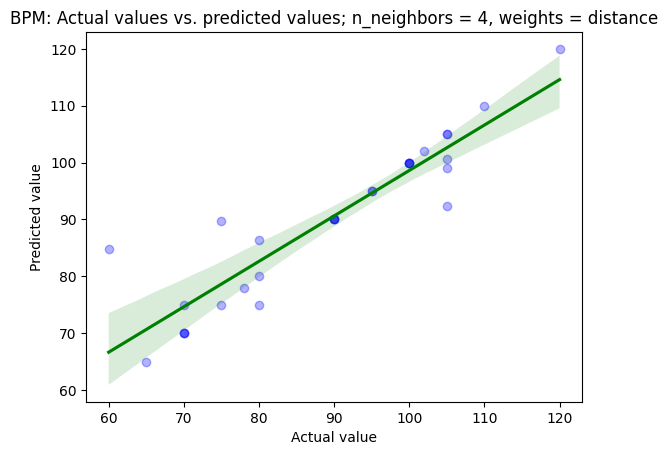

Accuracy: -0.11 (+/- 0.27)


In [9]:
build_test_knn_regressor(X,Y,X_train,Y_train,X_test,Y_test,weights='distance',n_neighbors=4,cv=3)

We may conclude that in this example weighting by distance helps prevent overfitting.